## Features Extracted (per wallet):
• Total deposit, borrow, repay, and redeemed USD amounts

• Number of actions of each type

• Average transaction value

• First and last activity timestamp

• Number of unique tokens interacted with

• Borrow-to-deposit ratio (as credit risk proxy)

In [29]:
import json
import pandas as pd
from datetime import datetime

In [30]:
# Load JSON
with open("user-wallet-transactions.json", "r") as f:
    data = json.load(f)

In [31]:
# Flatten and normalize
records = []
for tx in data:
    wallet = tx.get("userWallet")
    action = tx.get("action")
    timestamp = tx.get("timestamp")
    asset = tx["actionData"].get("assetSymbol", "UNKNOWN")
    price = float(tx["actionData"].get("assetPriceUSD", 0))
    raw_amount = float(tx["actionData"].get("amount", 0))
    
    # Determine decimals (simplified assumption)
    decimals = 6 if asset.upper() in ["USDC", "USDT", "DAI"] else 18
    amount = raw_amount / (10 ** decimals)
    usd_value = amount * price
    
    records.append({
        "wallet": wallet,
        "action": action,
        "timestamp": timestamp,
        "asset": asset,
        "usd_value": usd_value,
    })

In [32]:
# Convert to DataFrame
df = pd.DataFrame(records)
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")

In [33]:
# Pivot into wallet-level features: total & count per action
features = df.pivot_table(
    index="wallet", 
    columns="action", 
    values="usd_value", 
    aggfunc=["sum", "count"], 
    fill_value=0
)
features.columns = ["_".join(col).lower() for col in features.columns]

In [34]:
# Additional wallet stats
wallet_stats = df.groupby("wallet").agg({
    "usd_value": "mean",
    "timestamp": ["min", "max"],
    "asset": pd.Series.nunique
})
wallet_stats.columns = ["avg_tx_usd", "first_seen", "last_seen", "unique_assets"]

In [42]:
# Merge
final_df = features.merge(wallet_stats, left_index=True, right_index=True)
final_df.reset_index(inplace=True)

In [43]:
# Time-based features
final_df["activity_days"] = (final_df["last_seen"] - final_df["first_seen"]).dt.days + 1
final_df["tx_per_day"] = features.get("count_deposit", 0) / final_df["activity_days"]

In [44]:
# Borrow-to-Deposit ratio
final_df["borrow_deposit_ratio"] = final_df.get("sum_borrow", 0) / (final_df.get("sum_deposit", 1))

In [45]:
# Detect Repay Timestamps
repay_timestamps = df[df["action"] == "repay"].groupby("wallet")["timestamp"].max()

In [46]:
# Default Risk Heuristic
def has_default(wallet_row):
    borrowed = wallet_row.get("sum_borrow", 0)
    last_repay = repay_timestamps.get(wallet_row.name, pd.NaT)
    if borrowed > 0 and pd.isna(last_repay):
        return True
    if borrowed > 0 and (wallet_row["last_seen"] - last_repay).days > 90:
        return True
    return False

final_df["default_flag"] = final_df.apply(has_default, axis=1)

/var/folders/h3/dfkg91b132v83jnbsrrz538c0000gn/T/ipykernel_79026/882445453.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_repay = repay_timestamps.get(wallet_row.name, pd.NaT)


In [47]:
# Liquidation Event Detection
liquidations = df[df["action"] == "liquidationCall"].groupby("wallet")["action"].count()
final_df["liquidation_count"] = final_df["wallet"].map(liquidations).fillna(0).astype(int)
final_df["liquidated"] = final_df["liquidation_count"] > 0

In [48]:
# Time Between Transactions (Bot Detection)
df_sorted = df.sort_values(["wallet", "timestamp"])
df_sorted["prev_time"] = df_sorted.groupby("wallet")["timestamp"].shift(1)
df_sorted["time_diff"] = (df_sorted["timestamp"] - df_sorted["prev_time"]).dt.total_seconds()
avg_time_between_tx = df_sorted.groupby("wallet")["time_diff"].mean().fillna(999999)
final_df["avg_time_between_tx"] = final_df["wallet"].map(avg_time_between_tx)

In [49]:
# Bot-Like Behavior Heuristic
final_df["bot_like"] = (final_df["avg_time_between_tx"] < 60) & (final_df["unique_assets"] < 2)

In [50]:
# Reset index and save
final_df.reset_index(inplace=True)
final_df.to_csv("wallet_features.csv", index=False)

print("✅ Extracted features shape:", final_df.shape)
print(final_df[[
    "wallet", "sum_deposit", "sum_borrow", "borrow_deposit_ratio", 
    "default_flag", "liquidated", "liquidation_count", 
    "avg_time_between_tx", "bot_like"
]].head())

✅ Extracted features shape: (3497, 24)
                                       wallet   sum_deposit     sum_borrow  \
0  0x00000000001accfa9cef68cf5371a23025b6d4b6  1.987664e+03       0.000000   
1  0x000000000051d07a4fb3bd10121a343d85818da6  2.856945e+02       0.000000   
2  0x000000000096026fb41fc39f9875d164bd82e2dc  5.152311e-03       0.000000   
3  0x0000000000e189dd664b9ab08a33c4839953852c  0.000000e+00       0.000000   
4  0x0000000002032370b971dabd36d72f3e5a7bf1ee  4.149390e+16  130355.754756   

   borrow_deposit_ratio  default_flag  liquidated  liquidation_count  \
0          0.000000e+00         False       False                  0   
1          0.000000e+00         False       False                  0   
2          0.000000e+00         False       False                  0   
3                   NaN         False       False                  0   
4          3.141564e-12          True       False                  0   

   avg_time_between_tx  bot_like  
0        999999.000000  

# Load Engineered Features

In [51]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import numpy as np

In [52]:
# Load feature set
df = pd.read_csv("wallet_features.csv")

In [53]:
# Features to use for scoring (you can tune this list)
features = [
    "sum_deposit",
    "sum_borrow",
    "borrow_deposit_ratio",
    "tx_per_day",
    "unique_assets",
    "activity_days",
    "avg_tx_usd",
    "liquidation_count",
    "default_flag",
    "bot_like",
    "avg_time_between_tx"
]

In [54]:
# Clean and convert boolean to int
df["default_flag"] = df["default_flag"].astype(int)
df["bot_like"] = df["bot_like"].astype(int)

X = df[features].fillna(0)

In [65]:
# Replace inf and clip for stability
X["borrow_deposit_ratio"] = X["borrow_deposit_ratio"].replace([np.inf, -np.inf], 0)
X["borrow_deposit_ratio"] = X["borrow_deposit_ratio"].clip(upper=10)

In [66]:
# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [67]:
# Unsupervised scoring model: Isolation Forest (anomaly detection)
model = IsolationForest(n_estimators=200, contamination=0.1, random_state=42)
df["anomaly_score"] = model.fit_predict(X_scaled)  # -1 = outlier, 1 = normal
df["raw_score"] = model.decision_function(X_scaled)  # Higher is better

In [69]:
# Normalize raw scores to 0–1000 credit score
raw_min = df["raw_score"].min()
raw_max = df["raw_score"].max()
df["credit_score"] = ((df["raw_score"] - raw_min) / (raw_max - raw_min) * 1000).round().astype(int)

In [70]:
# Sort by most reliable
df.sort_values(by="credit_score", ascending=False, inplace=True)

In [71]:
# Export to CSV
df.to_csv("wallet_credit_scores.csv", index=False)

In [72]:
# Preview results
print("✅ Credit Scoring Complete. Sample:")
print(df[["wallet", "credit_score", "default_flag", "liquidation_count", "bot_like"]].head())

✅ Credit Scoring Complete. Sample:
                                          wallet  credit_score  default_flag  \
3201  0x0599da9dc8adf0baa33b49aba6e560a9486e61c3          1000         False   
1452  0x026cfe8238076c5500416ce21c6c3b3e00484494          1000         False   
653   0x010a078ff877852f0f18b6a910f7964ff18498f4          1000         False   
2659  0x049ed9ff140a2ad73db0cbd993771d16e86b4b5e          1000         False   
2662  0x049fd5a7f8d59517260baefa017b79c0ce19f0d0          1000         False   

      liquidation_count  bot_like  
3201                  0     False  
1452                  0     False  
653                   0     False  
2659                  0     False  
2662                  0     False  


# Number of users in each category

In [76]:
import matplotlib.pyplot as plt

In [77]:
# Load credit-scored data
df = pd.read_csv("wallet_credit_scores.csv")

In [78]:
# Categorize users by credit score
def categorize(score):
    if score >= 800:
        return "Excellent"
    elif score >= 600:
        return "Good"
    elif score >= 400:
        return "Fair"
    else:
        return "Risky"

df["category"] = df["credit_score"].apply(categorize)

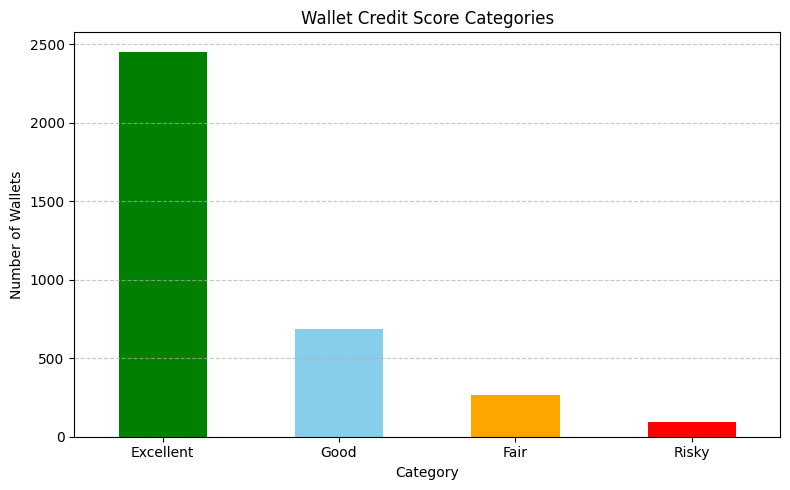

In [79]:
# Plot category distribution
category_counts = df["category"].value_counts().reindex(["Excellent", "Good", "Fair", "Risky"], fill_value=0)

plt.figure(figsize=(8, 5))
category_counts.plot(kind="bar", color=["green", "skyblue", "orange", "red"])
plt.title("Wallet Credit Score Categories")
plt.xlabel("Category")
plt.ylabel("Number of Wallets")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

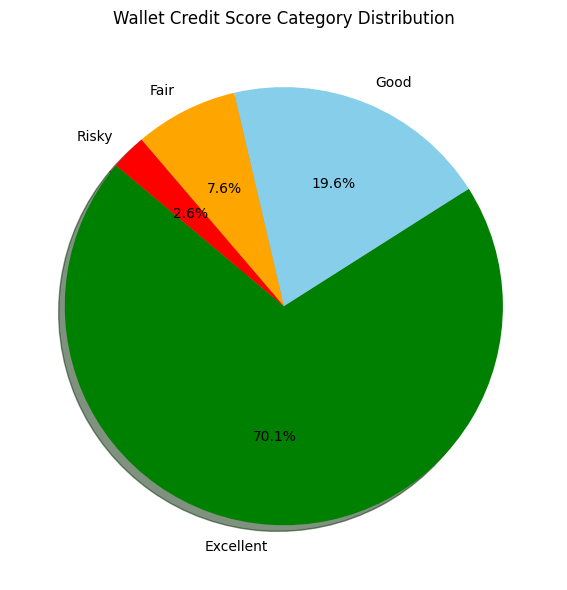

In [80]:
# Pie chart of categories
plt.figure(figsize=(6, 6))
colors = ["green", "skyblue", "orange", "red"]
df["category"].value_counts().reindex(["Excellent", "Good", "Fair", "Risky"]).plot(
    kind='pie', autopct='%1.1f%%', colors=colors, startangle=140, shadow=True)
plt.title("Wallet Credit Score Category Distribution")
plt.ylabel("")  # Hide y-label
plt.tight_layout()
plt.show()